In [1]:
import os
import numpy as np
from scipy.io import loadmat
import h5py
from preproc import *
from priordist import PriorDistributionCell

In [2]:
# Specify which day's dataset to use
prefix = "/Volumes/Hippocampus/Data/picasso-misc/"
day_dir = "20181102"

In [3]:
# Get list of cells under the day directory
os.system(f"sh ~/Documents/neural_decoding/Hippocampus_Decoding/get_cells.sh {day_dir}")
cell_list = list()
with open("cell_list.txt", "r") as file:
    for line in file.readlines():
        cell_list.append(line.strip())
os.system("rm cell_list.txt")

# Load data from rplparallel.mat object, extract trial markers, time stamps and session start timestamp
rp = h5py.File(prefix + day_dir + "/session01/rplparallel.mat")
rp = rp.get('rp').get('data')
trial_markers = np.array(rp.get('markers'))
trial_timestamps = np.array(rp.get('timeStamps'))
session_start_time = np.round(np.array(rp.get('session_start_sec'))[0,0], 3)

# Load data and extract spike times from all spiketrain.mat objects
spike_times = list()
cell_labels = list()
for cell_dir in cell_list:
    spk = loadmat(prefix + day_dir + "/session01/" + cell_dir + "/spiketrain.mat")
    spk = spk.get('timestamps').flatten() # spike timestamps is loaded in as a column vector
    spk = spk / 1000 # convert spike timestamps from msec to sec
    spike_times.append(spk)
    
    cell_name = cell_dir.split('/')
    array, channel, cell = cell_name[0][6:], cell_name[1][7:], cell_name[2][5:]
    if channel[0] == '0':
        channel = channel[1:]
    cell_labels.append(f'a{array}/ch{channel}/c{cell}')

# Load data from vmpv.mat object, extract session end timestamp
pv = h5py.File(prefix + day_dir + "/session01/1vmpv.mat")
pv = pv.get('pv').get('data')
session_end_time = np.round(np.array(pv.get('rplmaxtime'))[0,0], 3)

In [4]:
# Check outcomes of each trial
trial_outcomes = np.array(rp.get('markers'))
trial_outcomes = trial_outcomes[2,:] // 10
trial_outcomes = trial_outcomes.astype(int)

# Get frequencies of trial outcomes
trial_outcomes_freq = dict()
for trial in trial_outcomes:
    if trial not in trial_outcomes_freq:
        trial_outcomes_freq[trial] = 1
    else:
        trial_outcomes_freq[trial] += 1

print(trial_outcomes_freq)


{3: 400, 4: 41}


In [5]:
# Get poster numbers from trial markers, cue phase time intervals
trial_markers = trial_markers[0,:] % 10
trial_markers = trial_markers.astype(int)
cue_intervals = trial_timestamps[0:2,:].T

# Convert target posters to target pillars
def goal_to_pillar(goals: np.array) -> np.array:
    mapping = {1:3, 2:1, 3:4, 4:2, 5:2, 6:3}
    pillars = np.zeros_like(goals)
    for idx, goal in enumerate(goals):
        pillars[idx] = mapping[goal]
    return pillars
trial_markers = goal_to_pillar(trial_markers)

In [6]:
# Generate time intervals for navigation phases
nav_timestamps = trial_timestamps[1:,:].T

# Bin navigation phases into 1-second time bins
nav_intervals = list()
delta = 1  # Size of time bin (in seconds)
for idx, intvl in enumerate(nav_timestamps):
    nav_start, nav_end = intvl
    nav_intervals.append(np.vstack((np.arange(nav_start, nav_end - delta, delta), np.arange(nav_start + delta, nav_end, delta))).T)

In [7]:
# Generate time intervals for each trial
trial_intervals = np.empty_like(cue_intervals)
trial_intervals[:,0] = cue_intervals[:,1]
trial_intervals[:-1,1] = cue_intervals[1:,0]
trial_intervals[-1,1] = session_end_time

In [8]:
# Check number of time bins per trial
timebins_per_nav_phase = np.array(list(map(lambda arr: arr.shape[0], nav_intervals)))

# Filter out trials that are too long (> 25 seconds) or have repeated goal from previous trial
good_trials = np.ones(timebins_per_nav_phase.shape, dtype=np.int8)
max_dur = 25  # maximum duration of trials (in seconds) to filter out
prev_goal = 0
for num, dur in enumerate(timebins_per_nav_phase):
    curr_goal = trial_markers[num]
    if dur > max_dur or curr_goal == prev_goal:
        good_trials[num] = 0
    prev_goal = curr_goal
trial_filt = np.where(good_trials == 1)

trial_markers = trial_markers[trial_filt]
cue_intervals = cue_intervals[trial_filt,:][0]  # not sure why it adds an extra axis
new_nav_intervals = list()
for num, trial in enumerate(nav_intervals):
    if good_trials[num] == 1:
        new_nav_intervals.append(trial)
nav_intervals = new_nav_intervals
timebins_per_nav_phase = timebins_per_nav_phase[trial_filt]
trial_intervals = trial_intervals[trial_filt]

In [9]:
# Bin entire session into 1-second time bins, aligned to the end of each cue phase for each trial
session_intervals = list()
for idx, intvl in enumerate(trial_intervals):
    session_intervals.append(cue_intervals[idx,:])
    nav_start, nav_end = intvl
    for time in np.arange(nav_start, nav_end - 1, 1):
        session_intervals.append(np.array([time, time + 1]))
session_intervals = np.array(session_intervals)

In [10]:
# Slot spikes into cue phase intervals
spikecounts_cue = spike_counts_per_observation(cue_intervals, spike_times)

# Slot spikes into navigation phase intervals
spikecounts_nav = list()
for phase in nav_intervals:
    spikecounts_nav.append(spike_counts_per_observation(phase, spike_times))

# Slot spikes into session time intervals
spikecounts_session = spike_counts_per_observation(session_intervals, spike_times)

In [11]:
# Bin spike counts within each cell for entire sesion, and get firing rate thresholds used for binning
binned_spikes_session = np.empty_like(spikecounts_session)
binning_stats = list()
for col in range(spikecounts_session.shape[1]):
    binned_spikes_session[:,col] = bin_firing_rates_4(spikecounts_session[:,col])
    binning_stats.append(get_binning_stats_4(spikecounts_session[:,col]))

# Bin spike counts within each cell for cue phases
binned_spikes_cue = np.empty_like(spikecounts_cue)
for col in range(spikecounts_cue.shape[1]):
    binned_spikes_cue[:,col] = bin_firing_rates_4(spikecounts_cue[:,col], stats=binning_stats[col])

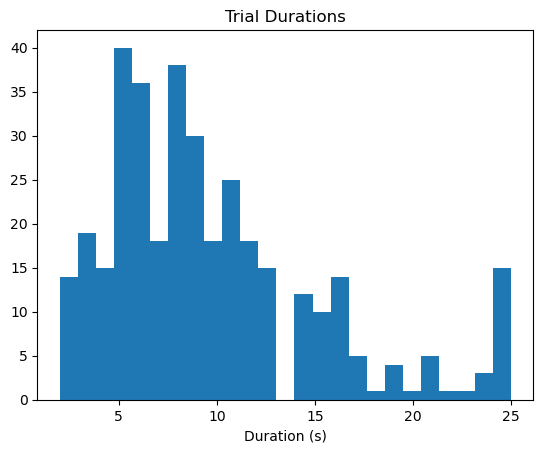

In [12]:
# Plot distribution of trial durations
import matplotlib.pyplot as plt

plt.figure()
plt.title('Trial Durations')
plt.hist(timebins_per_nav_phase, bins=25)
plt.xlabel('Duration (s)')
plt.show()

In [13]:
# Get quantiles of trial duration distribution
trial_dur_25 = np.percentile(timebins_per_nav_phase, 25)
trial_dur_50 = np.median(timebins_per_nav_phase)
trial_dur_75 = np.percentile(timebins_per_nav_phase, 75)
trial_dur_min = min(timebins_per_nav_phase)

print(f'Percentage of trials longer than __ seconds (sample size: {timebins_per_nav_phase.shape[0]}):')
print(f'25%: {trial_dur_75}, 50%: {trial_dur_50}, 75%: {trial_dur_25}, min: {trial_dur_min}')

Percentage of trials longer than __ seconds (sample size: 358):
25%: 12.0, 50%: 8.0, 75%: 6.0, min: 2


In [14]:
def group_by_pillar(timeseries: np.array, pillars: np.array) -> list:
    num_pillars = 4
    grouped = [np.empty((0, timeseries.shape[1])) for _ in range(num_pillars)]
    for idx, pillar in enumerate(pillars):
        pillar = int(pillar - 1)
        grouped[pillar] = np.vstack((grouped[pillar], timeseries[idx,:]))
    return grouped

def information_gain(response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    info_gain = np.zeros((num_goals, num_cells))
    for goal in range(num_goals):
        for cell in range(num_cells):
            for cat in range(num_cats):
                P_r_s = response_dist.P_r_s(cell, cat, goal)
                P_r = response_dist.P_r(cell, cat)
                if P_r_s != 0:
                    info_gain[goal, cell] += P_r_s * np.log2(P_r_s / P_r)
    return info_gain

def net_information_gain(info_gain: np.array, response_dist: PriorDistributionCell, constants: tuple) -> np.array:
    num_goals, num_cells, num_cats = constants
    net_info_gain = np.zeros(num_cells)
    for cell in range(num_cells):
        for goal in range(num_goals):
            I_s_R = info_gain[goal, cell]
            P_s = response_dist.P_s(goal)
            net_info_gain[cell] += P_s * I_s_R
    return net_info_gain

In [15]:
def net_information_gain_calc(data: tuple, constants: tuple) -> np.array:
    # Unpacking main data variables and constants
    binned_spikes_nav, binned_spikes_session, trial_markers = data
    num_goals, num_cells, num_cats = constants

    # Group cue phase spikes according to goal
    responses_per_goal_nav = group_by_pillar(binned_spikes_nav, trial_markers)

    # Get distribution of population responses for cue phase and navigation phase vs entire session
    response_distribution_nav = PriorDistributionCell(binned_spikes_session, responses_per_goal_nav)

    # Information gain per stimulus (relative to entire session responses)
    information_gain_nav = information_gain(response_distribution_nav, constants)

    # Net information gain acrosss entire stimuli set
    net_information_gain_nav = net_information_gain(information_gain_nav, response_distribution_nav, constants)
    return net_information_gain_nav


def bootstrap_estimate(data: tuple, constants: tuple, ratio: float, iters: int, intvl: tuple, replace=True, rng=np.random.default_rng()) -> tuple:
    # Unpack main data variables
    binned_spikes_nav, binned_spikes_session, trial_markers = data

    # Store net information gain ratio estimate from each bootstrapped sample
    estimates = list()

    # Big loop
    for i in range(iters):
        # Sampling with replacement
        num_samples = binned_spikes_nav.shape[0]
        num_subset = int(round(ratio * num_samples))
        indexes = tuple(rng.choice(num_samples, size=num_subset, replace=replace))
        binned_spikes_nav_subset = binned_spikes_nav[indexes,:]
        trial_markers_subset = trial_markers.reshape(-1,1)[indexes,:][:,0]

        # Calculate net information gain ratio for this sample
        data_subset = binned_spikes_nav_subset, binned_spikes_session, trial_markers_subset
        estimates.append(net_information_gain_calc(data_subset, constants))

    # Calculate bootstrapped mean and stdev
    est_mean = np.mean(estimates, axis=0)
    est_std = np.std(estimates, axis=0, ddof=1)
    est_intvl = (np.percentile(estimates, intvl[0], axis=0), np.percentile(estimates, intvl[1], axis=0))
    return est_mean, est_std, est_intvl


def nav_net_information_gain(data: tuple, constants: tuple, boot_params: tuple, time_diff: float, res=dict()) -> dict:
    # Unpacking main data variables and constants
    binned_spikes_session, binning_stats, trial_markers, spikecounts_nav = data
    num_goals, num_cells, num_cats = constants
    boot_ratio, boot_iters, boot_intvl, boot_replace = boot_params

    # Filter out trials with navigation phases less than time_diff seconds
    filt = np.where(timebins_per_nav_phase >= time_diff)
    trial_markers = trial_markers[filt]
    spikecounts_nav = list(filter(lambda arr: arr.shape[0] >= time_diff, spikecounts_nav))

    # Select time bin time_diff seconds after cue phase for each navigation phase
    spikecounts_nav = np.array(list(map(lambda arr: arr[time_diff-1,:], spikecounts_nav)))

    # Bin spike counts within each cell for navigation phases
    binned_spikes_nav = np.empty_like(spikecounts_nav)
    for col in range(spikecounts_nav.shape[1]):
        binned_spikes_nav[:,col] = bin_firing_rates_4(spikecounts_nav[:,col], stats=binning_stats[col])

    # Group cue phase spikes according to goal
    responses_per_goal_nav = group_by_pillar(binned_spikes_nav, trial_markers)

    # Get distribution of population responses for cue phase and navigation phase vs entire session
    response_distribution_nav = PriorDistributionCell(binned_spikes_session, responses_per_goal_nav)

    # Information gain per stimulus (relative to entire session responses)
    information_gain_nav = information_gain(response_distribution_nav, constants)

    # Net information gain acrosss entire stimuli set
    net_information_gain_nav = net_information_gain(information_gain_nav, response_distribution_nav, constants)

    # Bootstrap estimate of error
    boot_data = (binned_spikes_nav, binned_spikes_session, trial_markers)
    boot_mean, boot_std, boot_intvl = bootstrap_estimate(boot_data, constants, boot_ratio, boot_iters, boot_intvl, replace=boot_replace)

    # Write to result dictionary and return
    res[time_diff] = (net_information_gain_nav, boot_intvl)
    return res
    

In [16]:
# Some important constants
num_goals = 4
num_cells = len(cell_list)
num_cats = 4

# Pack session data
session_data = (binned_spikes_session, binning_stats, trial_markers, spikecounts_nav)
constants = (num_goals, num_cells, num_cats)

# Set params for bootstrapping estimation
boot_ratio = 0.8
boot_iters = 1000
boot_intvl = (1, 99)
boot_replace = False
boot_params = (boot_ratio, boot_iters, boot_intvl, boot_replace)

In [17]:
# Calculate net informaiton gain across all cue phases
responses_per_goal_cue = group_by_pillar(binned_spikes_cue, trial_markers)
response_distribution_cue = PriorDistributionCell(binned_spikes_session, responses_per_goal_cue)
information_gain_cue = information_gain(response_distribution_cue, constants)
net_information_gain_cue = net_information_gain(information_gain_cue, response_distribution_cue, constants)
cue_boot_mean, cue_boot_std, cue_boot_intvl = bootstrap_estimate((binned_spikes_cue, binned_spikes_session, trial_markers), constants, boot_ratio, boot_iters, boot_intvl)

In [18]:
# Shannon entropy across goals
goal_entropy = 0
for goal in range(num_goals):
    P_s = response_distribution_cue.P_s(goal)
    goal_entropy -= P_s * np.log2(P_s)

print(f'{goal_entropy}, {np.log2(6)}')

1.945816695236909, 2.584962500721156


In [19]:
# Run anaylsis across different time differences for navigation phase
results = {0: (net_information_gain_cue, cue_boot_intvl)}
# Get ratios of net information gain of cue against navigation phase
results_ratio = dict()
# Average ratio of net information gain between cue and navigation phase for each cell
average_ratio = np.zeros(num_cells)

for time_diff in range(1, int(trial_dur_50)+1):
    results = nav_net_information_gain(session_data, constants, boot_params, time_diff, res=results)
    results_ratio[time_diff] = np.divide(net_information_gain_cue, results[time_diff][0], out=np.zeros_like(net_information_gain_cue), where=results[time_diff][0]!=0)
    average_ratio += results_ratio[time_diff]

average_ratio /= num_cells
average_ratio = average_ratio.reshape(1,-1)

In [ ]:
# Change results from a dictionary to an array
results_arr = np.zeros((len(results), num_cells))
results_err_arr = np.zeros((len(results), num_cells, 2))
for time_diff, res in results.items():
    results_arr[time_diff,:] = res[0]
    results_err_arr[time_diff,:,0] = res[1][0]
    results_err_arr[time_diff,:,1] = res[1][1]
results_arr = results_arr.T
results_err_arr = np.swapaxes(results_err_arr, 0, 1)

# Change results_ratio from a dictionary to an array
results_ratio_arr = np.zeros((len(results_ratio), num_cells))
for time_diff, res in results_ratio.items():
    results_ratio_arr[time_diff-1,:] = res
results_ratio_arr = results_ratio_arr.T

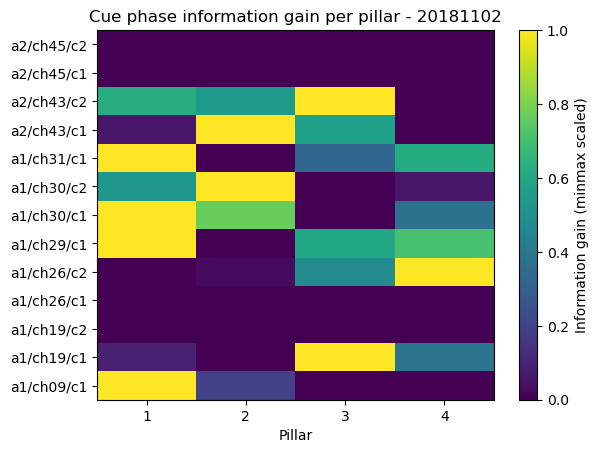

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

information_gain = information_gain_cue.T
information_gain_scaled = np.empty_like(information_gain)
for idx, row in enumerate(information_gain):
    information_gain_scaled[idx,:] = minmax_scale(row)

plt.figure()
plt.title(f'Cue phase information gain per pillar - {day_dir}')
plt.pcolormesh(information_gain_scaled)
plt.colorbar(label='Information gain (minmax scaled)')
plt.xlabel('Pillar')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_cells+0.5), labels=cell_labels)
plt.show()

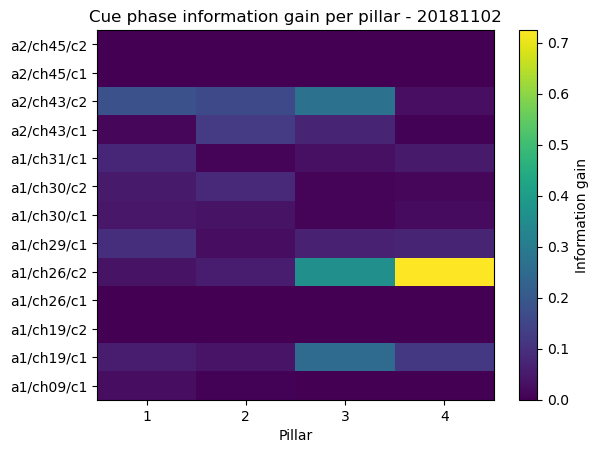

In [ ]:
plt.figure()
plt.title(f'Cue phase information gain per pillar - {day_dir}')
plt.pcolormesh(information_gain)
plt.colorbar(label='Information gain')
plt.xlabel('Pillar')
plt.xticks(np.arange(0.5, num_goals+0.5), labels=np.arange(1, num_goals+1))
plt.yticks(np.arange(0.5, num_cells+0.5), labels=cell_labels)
plt.show()

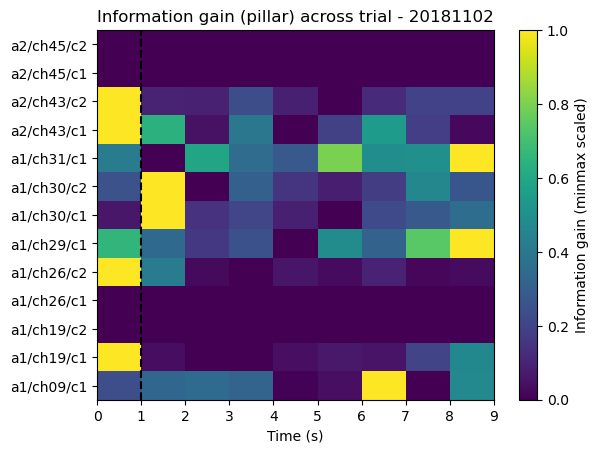

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

results_arr_scaled = np.empty_like(results_arr)
for idx, row in enumerate(results_arr):
    results_arr_scaled[idx,:] = minmax_scale(row)

plt.figure()
plt.title(f'Information gain (pillar) across trial - {day_dir}')
plt.pcolormesh(results_arr_scaled)
plt.colorbar(label='Information gain (minmax scaled)')
plt.axvline(x=1,color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.yticks(np.arange(0.5, num_cells+0.5), cell_labels)
plt.show()

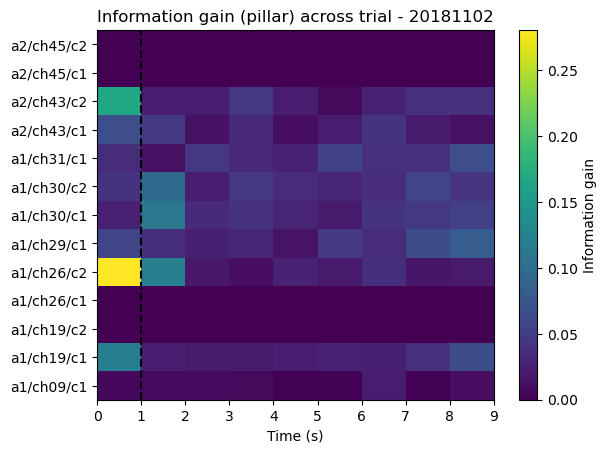

In [ ]:
plt.figure()
plt.title(f'Information gain (pillar) across trial - {day_dir}')
plt.pcolormesh(results_arr)
plt.colorbar(label='Information gain')
plt.axvline(x=1,color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.yticks(np.arange(0.5, num_cells+0.5), cell_labels)
plt.show()

Text(0, 0.5, 'Information gain')

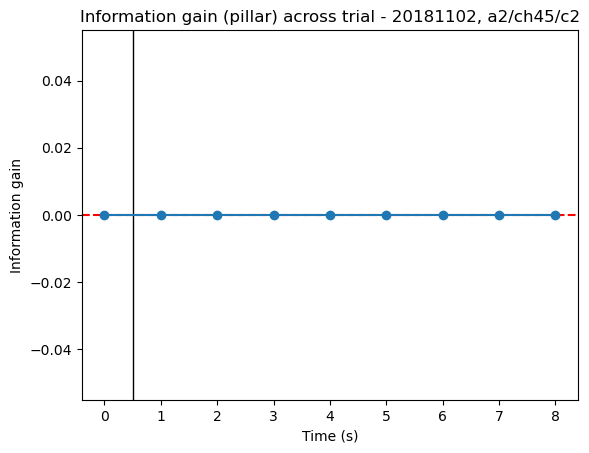

In [ ]:
# Select one cell to plot
cell_num = 12
cell_name = cell_labels[cell_num]

# Extract timeseries for one cell
cell_info = results_arr[cell_num,:]
cell_info_err_lo = results_arr[cell_num,:] - results_err_arr[cell_num,:,0]
cell_info_err_hi = results_err_arr[cell_num,:,1] - results_arr[cell_num,:]
cell_info_err = (cell_info_err_lo, cell_info_err_hi)

plt.figure()
plt.title(f'Information gain (pillar) across trial - {day_dir}, {cell_name}')
plt.errorbar(np.arange(cell_info.shape[0]), cell_info, yerr=cell_info_err, fmt='-o', elinewidth=1, capsize=3)
plt.axhline(y=cell_info[0], color='r', linestyle='--')
plt.axvline(x=0.5, color='k', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Information gain')